In [1]:
import os
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import glob
import missingno as msno
from scipy.stats import ttest_ind
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

### Cargue de datos

In [2]:
# cargar los datos en csv
data = pd.read_csv('dataset_3.csv',
                   sep=';', #Parámetro de separación de datos
                   encoding='utf-8' #Codificación de datos
                  )
data.drop(data.columns[0],axis=1,inplace=True)
print(data.shape)
#visualizar los primeros registros
data.head(5)

(5029969, 18)


,coord_y,coord_x,Cobertura,Curvatura,Distancia_Drenajes,Distancia_Fallas,Distancia_Vias,DTM,Geologia,Geomorfologia,NDVI,Orientaciones,Rugosidad,Slope,TPI,UGS,is_slide,slide_FK
0,637085.126257,965898.966867,7.0,-1.972500,80.039055,8860.464,37.500000,2551.3591,7.0,12.0,0.209492,355.293000,255.0,5.959947,15.154297,8.0,False,0.0
1,637072.626257,965898.966867,7.0,1.644062,88.388350,8852.269,25.000000,2554.2786,7.0,12.0,0.209492,14.471906,255.0,6.341040,17.635742,8.0,False,0.0
2,637110.126257,965911.466867,7.0,2.063750,72.886900,8867.471,63.737743,2547.0962,7.0,12.0,0.209140,63.449420,255.0,13.375040,12.150391,8.0,False,0.0
3,637097.626257,965911.466867,7.0,2.821250,80.039055,8859.246,51.538822,2549.3420,7.0,12.0,0.209140,48.567110,255.0,14.689607,13.618164,8.0,False,0.0
4,637085.126257,965911.466867,7.0,2.158594,88.388350,8851.033,39.528470,2551.5217,7.0,12.0,0.209492,40.382770,255.0,13.636049,15.251465,8.0,False,0.0


### Data Check

In [3]:
print(f"Hay datos duplicados? {data.duplicated().any()}")
print(f"Hay datos duplicados? \n{data.isna().any()}") 
data.shape

Hay datos duplicados? False
Hay datos duplicados? 
coord_y               False
coord_x               False
Cobertura             False
Curvatura             False
Distancia_Drenajes    False
Distancia_Fallas      False
Distancia_Vias        False
DTM                   False
Geologia              False
Geomorfologia         False
NDVI                  False
Orientaciones         False
Rugosidad             False
Slope                 False
TPI                   False
UGS                   False
is_slide              False
slide_FK              False
dtype: bool


(5029969, 18)

### Preprocesamiento
Se filtraran lo datos basados en algunas reglas de negocio y valores atipicos, siempre y cuando esto no disminuya el numero de puntos de derrumbes en el dataset.

In [4]:
# Filtrar outliers de Curvatura: menores a -10 y mayores a 10
print(f'Se filtran {data.Curvatura[(data.Curvatura<-10)|(data.Curvatura>10)].shape} registros')
data_1 = data.loc[(data.Curvatura>-10)&(data.Curvatura<10)]

Se filtran (2424,) registros


In [5]:
# Filtrar outliers de NDVI: mayor a 0.6
print(f'Se filtran {data_1.NDVI[data_1.NDVI>0.6].shape} registros')
data_1 = data_1.loc[(data_1.NDVI<0.6)]

Se filtran (862,) registros


In [6]:
# Filtrar outliers TPI: menor que -85 y mayor que 85
print(f'Se filtran {data_1.TPI[(data_1.TPI<-85)|(data_1.TPI>85)].shape} registros')
data_1 = data_1.loc[(data_1.TPI>-85)&(data_1.TPI<85)]

Se filtran (1201,) registros


In [7]:
# Filtrar cuerpos de agua residuales
print(f'Se filtran {data_1[(data_1.Geologia==1)|(data_1.Geomorfologia==1)].shape} registros')
data_1 = data_1.loc[(data_1.Geologia!=1)&(data_1.Geomorfologia!=1)]
data_1.shape

Se filtran (321, 18) registros


(5025159, 18)

### Ingenieria de Caracteristicas
Crearemos una variable con base en la cercania de los puntos a derrumbes historicos, de tal forma que todos los puntos en un "radio" de 25 metros al rededor de un derrumbe marquen "TRUE" para la variable "is_close2slide" 

In [8]:
data_1['is_close2slide'] = 0
n=1
for index, row in data_1[data_1.is_slide==True].iterrows():
    data_1.loc[(data_1.coord_x.between(row.coord_x-12.5*n,row.coord_x+12.5*n,inclusive='both')) &
               (data_1.coord_y.between(row.coord_y-12.5*n,row.coord_y+12.5*n,inclusive='both')) &
               (data_1.index != index),
               ['is_close2slide']] = 1

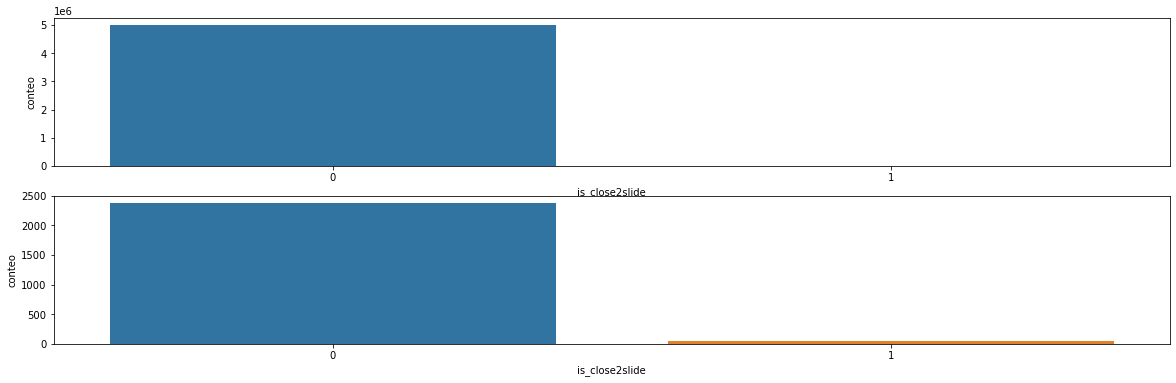

In [9]:
%matplotlib inline
# Podemos utilizar la tabla de frecuencias para realizar el gráfico
data_close2slide = data_1.groupby(['is_slide','is_close2slide']).size().reset_index(name="cnt")
# cambiamos el nombre de las columnas
data_close2slide.columns=['derrumbe','is_close2slide','conteo']
fig, ax = plt.subplots(2, 1,figsize=(20,6))
sns.barplot(x = 'is_close2slide', y = "conteo", data = data_close2slide[data_close2slide.derrumbe==0], ax=ax[0])
sns.barplot(x = 'is_close2slide', y = "conteo", data = data_close2slide[data_close2slide.derrumbe==1], ax=ax[1])
plt.show()

In [10]:
data_1.head()

,coord_y,coord_x,Cobertura,Curvatura,Distancia_Drenajes,Distancia_Fallas,Distancia_Vias,DTM,Geologia,Geomorfologia,NDVI,Orientaciones,Rugosidad,Slope,TPI,UGS,is_slide,slide_FK,is_close2slide
0,637085.126257,965898.966867,7.0,-1.972500,80.039055,8860.464,37.500000,2551.3591,7.0,12.0,0.209492,355.293000,255.0,5.959947,15.154297,8.0,False,0.0,0
1,637072.626257,965898.966867,7.0,1.644062,88.388350,8852.269,25.000000,2554.2786,7.0,12.0,0.209492,14.471906,255.0,6.341040,17.635742,8.0,False,0.0,0
2,637110.126257,965911.466867,7.0,2.063750,72.886900,8867.471,63.737743,2547.0962,7.0,12.0,0.209140,63.449420,255.0,13.375040,12.150391,8.0,False,0.0,0
3,637097.626257,965911.466867,7.0,2.821250,80.039055,8859.246,51.538822,2549.3420,7.0,12.0,0.209140,48.567110,255.0,14.689607,13.618164,8.0,False,0.0,0
4,637085.126257,965911.466867,7.0,2.158594,88.388350,8851.033,39.528470,2551.5217,7.0,12.0,0.209492,40.382770,255.0,13.636049,15.251465,8.0,False,0.0,0


## Anaisis de variables

### Prueba de hipotesis

In [11]:
var = 'TPI'
p_H0 = data_1[data_1['is_slide']== False][var]
p_H1 = data_1[data_1['is_slide']== True][var]
print(f'Promedio de el {var} para los no derrumbes es: {str(p_H0.mean())}')
print(f'Promedio de el {var} sistolica para los derrumbes es: {str(p_H1.mean())}')

Promedio de el TPI para los no derrumbes es: 0.4056426718656773
Promedio de el TPI sistolica para los derrumbes es: -1.8283206636382265


In [12]:
ttest,pval = ttest_ind(p_H0,p_H1)
print('Valor de t: '+str(ttest))
print('Valor p: '+ str(pval))

# Regla de decisión si el p valor es menor que la significancia escogida 
confianza=0.95
significancia=1-confianza
# Si se tiene menor valor se rechaza la hipótesis nula
if pval<significancia:
    print("Rechazar hipótesis nula")
else:
    print("No rechazar hipótesis nula")

Valor de t: 6.843583545330837
Valor p: 7.724503118427775e-12
Rechazar hipótesis nula


### Correlaciones

In [13]:
#Se descartan las variables categoricas y para las cuales no se pudo rechazar la hipotesis nula.
df_corr = data_1.drop(['coord_y','coord_x','Cobertura','Geologia','Geomorfologia',
                       'UGS','is_slide','slide_FK', 'Distancia_Drenajes'], 1)
corr = df_corr.corr()
corr

,Curvatura,Distancia_Fallas,Distancia_Vias,DTM,NDVI,Orientaciones,Rugosidad,Slope,TPI,is_close2slide
Curvatura,1.000000,-0.000521,-0.001176,0.045474,-0.004918,-0.000745,-0.003924,0.008363,0.497388,-0.003058
Distancia_Fallas,-0.000521,1.000000,0.096936,0.051104,-0.065479,-0.003306,-0.010848,0.007781,-0.003619,-0.015853
Distancia_Vias,-0.001176,0.096936,1.000000,-0.157041,-0.316796,0.035145,-0.106103,0.334652,0.000528,-0.012161
DTM,0.045474,0.051104,-0.157041,1.000000,-0.276925,-0.020699,0.011671,-0.065787,0.155366,0.015241
NDVI,-0.004918,-0.065479,-0.316796,-0.276925,1.000000,-0.078116,0.023429,-0.017821,-0.017476,0.007953
Orientaciones,-0.000745,-0.003306,0.035145,-0.020699,-0.078116,1.000000,0.493976,-0.020279,-0.005939,-0.008041
Rugosidad,-0.003924,-0.010848,-0.106103,0.011671,0.023429,0.493976,1.000000,-0.244026,-0.005984,-0.010575
Slope,0.008363,0.007781,0.334652,-0.065787,-0.017821,-0.020279,-0.244026,1.000000,0.033755,0.017730
TPI,0.497388,-0.003619,0.000528,0.155366,-0.017476,-0.005939,-0.005984,0.033755,1.000000,-0.008835
is_close2slide,-0.003058,-0.015853,-0.012161,0.015241,0.007953,-0.008041,-0.010575,0.017730,-0.008835,1.000000


<AxesSubplot:>

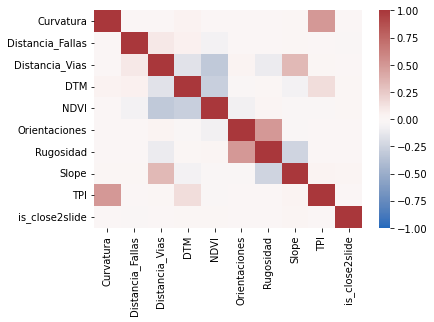

In [14]:
#Realizar el gráfico de correlación
sns.heatmap(corr,
            vmin=-1.00, vmax=1.00,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="vlag")

### Preparacion de Datasets de entrenamiento

In [19]:
# Se selecciona la variable objetivo, en este caso "TARGET".
Y = data_1.is_slide
# Del conjunto de datos se elimina la variable "TARGET".
X = data_1.drop(['coord_y','coord_x','Cobertura','Geomorfologia','UGS','slide_FK','Distancia_Drenajes','is_slide'], 1)

In [20]:
X = pd.get_dummies(X, columns=['Geologia'], drop_first=True, prefix=['Geo'])

In [21]:
scaler = preprocessing.StandardScaler()
X.iloc[:, :9] = scaler.fit_transform(X.iloc[:, :9])
pd.DataFrame(X)

,Curvatura,Distancia_Fallas,Distancia_Vias,DTM,NDVI,Orientaciones,Rugosidad,Slope,TPI,is_close2slide,...,Geo_19.0,Geo_20.0,Geo_21.0,Geo_22.0,Geo_23.0,Geo_24.0,Geo_25.0,Geo_26.0,Geo_27.0,Geo_28.0
0,-1.856069,3.517984,-0.576946,-1.381002,0.778075,1.628758,1.845775,-1.319342,0.915332,0,...,0,0,0,0,0,0,0,0,0,0
1,1.540985,3.513614,-0.580745,-1.372281,0.778075,-1.666146,1.845775,-1.280677,1.069324,0,...,0,0,0,0,0,0,0,0,0,0
2,1.935199,3.521720,-0.568971,-1.393736,0.774893,-1.192654,1.845775,-0.567021,0.728917,0,...,0,0,0,0,0,0,0,0,0,0
3,2.646722,3.517334,-0.572679,-1.387028,0.774893,-1.336529,1.845775,-0.433647,0.820003,0,...,0,0,0,0,0,0,0,0,0,0
4,2.024286,3.512955,-0.576329,-1.380516,0.778075,-1.415652,1.845775,-0.540539,0.921362,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029964,0.380503,1.904209,0.676680,1.258653,-0.529354,-0.121840,-0.257801,-1.070470,0.233411,0,...,0,0,0,0,0,0,0,0,0,0
5029965,0.297287,1.899443,0.678259,1.252678,-0.529354,-0.035267,1.845775,-1.127833,0.144173,0,...,0,0,0,0,0,0,0,0,0,0
5029966,-0.389727,1.894683,0.679848,1.246704,-0.529354,-0.035666,1.845775,-1.267027,0.056345,0,...,0,0,0,0,0,0,0,0,0,0
5029967,0.318421,1.908868,0.680138,1.257941,-0.529354,-0.093468,1.845775,-1.280619,0.170248,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Se realiza la división entrenamiento - test. Se deja 20% de los datos para el test.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, stratify=Y, random_state = 9)

### Seleccion de variables

In [30]:
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

         Current function value: 0.004049
         Iterations: 35


C:\Users\gvargasj\.conda\envs\MINE-DS\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517574
Method:                           MLE   Df Model:                           36
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.03329
Time:                        20:20:22   Log-Likelihood:                -14242.
converged:                      False   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                1.659e-182
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.2118      0.135    -60.644      0.000      -8.477      -7.946
Curvatura            0.0018      0.025      0.071      0.944      -0.048       0.052
Distancia_Fallas    -0.2184      0.030     -7.238      0.000      -0.278      -0.159
Distancia_Vias      -0.3205      0.046     -6.973      0.000      -0.411      -0.230
DTM                  0.3118      0.031     10.041      0.000       0.251       0.373
NDVI                 0.1596      0.025      6.403      0.000       0.111       0.209
Orientaciones       -0.0392      0.029     -1.373      0.170      -0.095       0.017
Rugosidad           -0.0851      0.026     -3.248      0.001      -0.137      -0.034
Slope                0.3086      0.025     12.122      0.000       0.259       0.358
TPI                 -0.1905      0.027     -6.971      0.000      -0.244      -0.137
is_close2slide       1.2058      0.170      7.107      0.000       0.873       1.538
Geo_3.0              0.9973      0.522      1.910      0.056      -0.026       2.021
Geo_4.0              0.4906      0.225      2.184      0.029       0.050       0.931
Geo_5.0             -0.9529      0.316     -3.017      0.003      -1.572      -0.334
Geo_6.0              0.0357      0.209      0.171      0.864      -0.373       0.444
Geo_7.0              0.4405      0.142      3.094      0.002       0.161       0.720
Geo_8.0              0.3815      0.384      0.992      0.321      -0.372       1.135
Geo_9.0              0.7523      0.282      2.665      0.008       0.199       1.305
Geo_10.0             2.7293      0.243     11.250      0.000       2.254       3.205
Geo_11.0             0.3402      0.156      2.184      0.029       0.035       0.646
Geo_12.0            -9.7792    326.339     -0.030      0.976    -649.391     629.833
Geo_13.0            -1.0631     15.341     -0.069      0.945     -31.131      29.004
Geo_14.0             0.5466      0.721      0.758      0.449      -0.867       1.961
Geo_15.0             0.3342      1.011      0.330      0.741      -1.648       2.316
Geo_16.0          -689.9059        inf         -0      1.000        -inf         inf
Geo_17.0            -9.8827    180.931     -0.055      0.956    -364.500     344.735
Geo_18.0             0.0204      0.405      0.050      0.960      -0.773       0.813
Geo_19.0             1.3837      0.403      3.435      0.001       0.594       2.173
Geo_20.0             0.0212      0.595      0.036      0.972      -1.145       1.188
Geo_21.0            -8.4412    432.204     -0.020      0.984    -855.545     838.662
Geo_22.0             0.0832      0.432      0.192      0.847      -0.764       0.931
Geo_23.0             0.6928      0.382      1.811      0.070      -0.057       1.442
Geo_24.0             0.2634      0.405      0.651      0.515      -0.530       1.057
Geo_25.0             0.1507      0.597      0.252      0.801      -1.020       1.322
Geo_26.0           -11.6226    344.775     -0.034      0.973    -687.368     664.123
Geo_27.0   

In [31]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Geo_12.0','Geo_13.0','Geo_16.0','Geo_21.0'], axis=1)
X_test = X_test.drop(['Geo_12.0','Geo_13.0','Geo_16.0','Geo_21.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

         Current function value: 0.004049
         Iterations: 35


C:\Users\gvargasj\.conda\envs\MINE-DS\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517578
Method:                           MLE   Df Model:                           32
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.03327
Time:                        20:23:11   Log-Likelihood:                -14242.
converged:                      False   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                2.265e-185
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.2155      0.135    -60.690      0.000      -8.481      -7.950
Curvatura            0.0018      0.025      0.071      0.944      -0.048       0.052
Distancia_Fallas    -0.2183      0.030     -7.236      0.000      -0.277      -0.159
Distancia_Vias      -0.3200      0.046     -6.963      0.000      -0.410      -0.230
DTM                  0.3120      0.031     10.044      0.000       0.251       0.373
NDVI                 0.1598      0.025      6.408      0.000       0.111       0.209
Orientaciones       -0.0392      0.029     -1.372      0.170      -0.095       0.017
Rugosidad           -0.0851      0.026     -3.248      0.001      -0.137      -0.034
Slope                0.3087      0.025     12.127      0.000       0.259       0.359
TPI                 -0.1905      0.027     -6.970      0.000      -0.244      -0.137
is_close2slide       1.2058      0.170      7.107      0.000       0.873       1.538
Geo_3.0              1.0014      0.522      1.917      0.055      -0.022       2.025
Geo_4.0              0.4947      0.225      2.202      0.028       0.054       0.935
Geo_5.0             -0.9490      0.316     -3.005      0.003      -1.568      -0.330
Geo_6.0              0.0393      0.209      0.188      0.851      -0.369       0.448
Geo_7.0              0.4443      0.142      3.122      0.002       0.165       0.723
Geo_8.0              0.3853      0.384      1.003      0.316      -0.368       1.139
Geo_9.0              0.7562      0.282      2.679      0.007       0.203       1.309
Geo_10.0             2.7329      0.243     11.265      0.000       2.257       3.208
Geo_11.0             0.3440      0.156      2.208      0.027       0.039       0.649
Geo_14.0             0.5507      0.721      0.763      0.445      -0.863       1.965
Geo_15.0             0.3382      1.011      0.334      0.738      -1.644       2.320
Geo_17.0           -10.3215    225.761     -0.046      0.964    -452.805     432.162
Geo_18.0             0.0245      0.405      0.061      0.952      -0.768       0.817
Geo_19.0             1.3875      0.403      3.444      0.001       0.598       2.177
Geo_20.0             0.0252      0.595      0.042      0.966      -1.141       1.192
Geo_22.0             0.0873      0.432      0.202      0.840      -0.760       0.935
Geo_23.0             0.6970      0.382      1.822      0.068      -0.053       1.447
Geo_24.0             0.2675      0.405      0.661      0.509      -0.526       1.061
Geo_25.0             0.1543      0.597      0.258      0.796      -1.016       1.325
Geo_26.0           -11.7241    363.486     -0.032      0.974    -724.144     700.696
Geo_27.0             0.2592      0.264      0.983      0.325      -0.257       0.776
Geo_28.0             0.9189      0.238      3.854      0.000       0.452       1.386
====================================================================================
"""

In [32]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Curvatura','Geo_20.0'], axis=1)
X_test = X_test.drop(['Curvatura','Geo_20.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

         Current function value: 0.004049
         Iterations: 35


C:\Users\gvargasj\.conda\envs\MINE-DS\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517580
Method:                           MLE   Df Model:                           30
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.03327
Time:                        20:25:27   Log-Likelihood:                -14242.
converged:                      False   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                6.938e-187
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.2142      0.132    -62.456      0.000      -8.472      -7.956
Distancia_Fallas    -0.2183      0.030     -7.237      0.000      -0.277      -0.159
Distancia_Vias      -0.3202      0.046     -6.997      0.000      -0.410      -0.230
DTM                  0.3119      0.031     10.050      0.000       0.251       0.373
NDVI                 0.1597      0.025      6.408      0.000       0.111       0.209
Orientaciones       -0.0391      0.029     -1.371      0.170      -0.095       0.017
Rugosidad           -0.0851      0.026     -3.248      0.001      -0.137      -0.034
Slope                0.3086      0.025     12.139      0.000       0.259       0.358
TPI                 -0.1896      0.024     -7.894      0.000      -0.237      -0.142
is_close2slide       1.2059      0.170      7.107      0.000       0.873       1.538
Geo_3.0              1.0000      0.521      1.919      0.055      -0.021       2.021
Geo_4.0              0.4933      0.222      2.222      0.026       0.058       0.928
Geo_5.0             -0.9505      0.314     -3.028      0.002      -1.566      -0.335
Geo_6.0              0.0380      0.206      0.185      0.854      -0.366       0.442
Geo_7.0              0.4429      0.139      3.198      0.001       0.171       0.714
Geo_8.0              0.3838      0.383      1.003      0.316      -0.367       1.134
Geo_9.0              0.7549      0.281      2.690      0.007       0.205       1.305
Geo_10.0             2.7319      0.240     11.376      0.000       2.261       3.203
Geo_11.0             0.3427      0.152      2.250      0.024       0.044       0.641
Geo_14.0             0.5492      0.721      0.762      0.446      -0.863       1.962
Geo_15.0             0.3364      1.011      0.333      0.739      -1.644       2.317
Geo_17.0           -10.3205    225.472     -0.046      0.963    -452.237     431.596
Geo_18.0             0.0232      0.403      0.058      0.954      -0.767       0.813
Geo_19.0             1.3862      0.402      3.452      0.001       0.599       2.173
Geo_22.0             0.0859      0.431      0.199      0.842      -0.759       0.931
Geo_23.0             0.6955      0.381      1.826      0.068      -0.051       1.442
Geo_24.0             0.2660      0.403      0.660      0.509      -0.524       1.056
Geo_25.0             0.1531      0.596      0.257      0.797      -1.016       1.322
Geo_26.0           -11.7243    363.274     -0.032      0.974    -723.728     700.280
Geo_27.0             0.2581      0.262      0.986      0.324      -0.255       0.771
Geo_28.0             0.9174      0.236      3.888      0.000       0.455       1.380
====================================================================================
"""

In [33]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Geo_17.0','Geo_18.0','Geo_26.0'], axis=1)
X_test = X_test.drop(['Geo_17.0','Geo_18.0','Geo_26.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004049
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517583
Method:                           MLE   Df Model:                           27
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.03317
Time:                        20:26:47   Log-Likelihood:                -14244.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                1.425e-188
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.2362      0.124    -66.597      0.000      -8.479      -7.994
Distancia_Fallas    -0.2196      0.030     -7.292      0.000      -0.279      -0.161
Distancia_Vias      -0.3168      0.045     -6.981      0.000      -0.406      -0.228
DTM                  0.3118      0.031     10.042      0.000       0.251       0.373
NDVI                 0.1600      0.025      6.417      0.000       0.111       0.209
Orientaciones       -0.0389      0.029     -1.362      0.173      -0.095       0.017
Rugosidad           -0.0852      0.026     -3.252      0.001      -0.137      -0.034
Slope                0.3091      0.025     12.205      0.000       0.259       0.359
TPI                 -0.1894      0.024     -7.886      0.000      -0.236      -0.142
is_close2slide       1.2061      0.170      7.109      0.000       0.874       1.539
Geo_3.0              1.0226      0.519      1.971      0.049       0.006       2.040
Geo_4.0              0.5165      0.216      2.386      0.017       0.092       0.941
Geo_5.0             -0.9254      0.310     -2.983      0.003      -1.533      -0.317
Geo_6.0              0.0611      0.201      0.304      0.761      -0.333       0.455
Geo_7.0              0.4654      0.131      3.561      0.000       0.209       0.722
Geo_8.0              0.4063      0.380      1.070      0.285      -0.338       1.151
Geo_9.0              0.7766      0.277      2.801      0.005       0.233       1.320
Geo_10.0             2.7539      0.236     11.684      0.000       2.292       3.216
Geo_11.0             0.3653      0.145      2.516      0.012       0.081       0.650
Geo_14.0             0.5721      0.719      0.796      0.426      -0.837       1.981
Geo_15.0             0.3606      1.009      0.357      0.721      -1.618       2.339
Geo_19.0             1.4072      0.399      3.527      0.000       0.625       2.189
Geo_22.0             0.1086      0.428      0.254      0.800      -0.731       0.948
Geo_23.0             0.7193      0.378      1.905      0.057      -0.021       1.459
Geo_24.0             0.2886      0.400      0.721      0.471      -0.496       1.073
Geo_25.0             0.1772      0.595      0.298      0.766      -0.988       1.343
Geo_27.0             0.2795      0.258      1.084      0.278      -0.226       0.785
Geo_28.0             0.9408      0.231      4.077      0.000       0.488       1.393
====================================================================================
"""

In [34]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Geo_6.0','Geo_15.0','Geo_22.0'], axis=1)
X_test = X_test.drop(['Geo_6.0','Geo_15.0','Geo_22.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004049
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517586
Method:                           MLE   Df Model:                           24
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.03316
Time:                        20:29:30   Log-Likelihood:                -14244.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                6.308e-191
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.2056      0.092    -89.493      0.000      -8.385      -8.026
Distancia_Fallas    -0.2189      0.030     -7.299      0.000      -0.278      -0.160
Distancia_Vias      -0.3205      0.044     -7.249      0.000      -0.407      -0.234
DTM                  0.3138      0.030     10.528      0.000       0.255       0.372
NDVI                 0.1614      0.024      6.696      0.000       0.114       0.209
Orientaciones       -0.0389      0.029     -1.363      0.173      -0.095       0.017
Rugosidad           -0.0855      0.026     -3.266      0.001      -0.137      -0.034
Slope                0.3087      0.025     12.216      0.000       0.259       0.358
TPI                 -0.1898      0.024     -7.912      0.000      -0.237      -0.143
is_close2slide       1.2060      0.170      7.108      0.000       0.873       1.539
Geo_3.0              0.9905      0.511      1.937      0.053      -0.012       1.993
Geo_4.0              0.4834      0.197      2.454      0.014       0.097       0.869
Geo_5.0             -0.9589      0.297     -3.233      0.001      -1.540      -0.378
Geo_7.0              0.4333      0.097      4.476      0.000       0.244       0.623
Geo_8.0              0.3732      0.369      1.012      0.311      -0.349       1.096
Geo_9.0              0.7470      0.266      2.810      0.005       0.226       1.268
Geo_10.0             2.7173      0.211     12.896      0.000       2.304       3.130
Geo_11.0             0.3330      0.115      2.898      0.004       0.108       0.558
Geo_14.0             0.5413      0.714      0.758      0.449      -0.859       1.942
Geo_19.0             1.3794      0.392      3.516      0.000       0.611       2.148
Geo_23.0             0.6879      0.368      1.867      0.062      -0.034       1.410
Geo_24.0             0.2583      0.392      0.659      0.510      -0.510       1.027
Geo_25.0             0.1442      0.588      0.245      0.806      -1.008       1.296
Geo_27.0             0.2482      0.243      1.021      0.307      -0.228       0.725
Geo_28.0             0.9091      0.215      4.231      0.000       0.488       1.330
====================================================================================
"""

In [35]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Geo_14.0','Geo_24.0','Geo_25.0'], axis=1)
X_test = X_test.drop(['Geo_14.0','Geo_24.0','Geo_25.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004049
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517589
Method:                           MLE   Df Model:                           21
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.03313
Time:                        20:31:45   Log-Likelihood:                -14244.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                3.203e-193
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.1830      0.087    -93.804      0.000      -8.354      -8.012
Distancia_Fallas    -0.2191      0.030     -7.331      0.000      -0.278      -0.161
Distancia_Vias      -0.3233      0.044     -7.340      0.000      -0.410      -0.237
DTM                  0.3123      0.030     10.507      0.000       0.254       0.371
NDVI                 0.1598      0.024      6.652      0.000       0.113       0.207
Orientaciones       -0.0382      0.029     -1.340      0.180      -0.094       0.018
Rugosidad           -0.0850      0.026     -3.249      0.001      -0.136      -0.034
Slope                0.3075      0.025     12.197      0.000       0.258       0.357
TPI                 -0.1899      0.024     -7.919      0.000      -0.237      -0.143
is_close2slide       1.2062      0.170      7.109      0.000       0.874       1.539
Geo_3.0              0.9668      0.511      1.893      0.058      -0.034       1.968
Geo_4.0              0.4597      0.195      2.359      0.018       0.078       0.842
Geo_5.0             -0.9827      0.295     -3.331      0.001      -1.561      -0.404
Geo_7.0              0.4109      0.093      4.435      0.000       0.229       0.592
Geo_8.0              0.3506      0.368      0.954      0.340      -0.370       1.071
Geo_9.0              0.7249      0.264      2.741      0.006       0.207       1.243
Geo_10.0             2.6978      0.209     12.912      0.000       2.288       3.107
Geo_11.0             0.3112      0.112      2.791      0.005       0.093       0.530
Geo_19.0             1.3535      0.391      3.461      0.001       0.587       2.120
Geo_23.0             0.6620      0.367      1.803      0.071      -0.058       1.382
Geo_27.0             0.2271      0.242      0.940      0.347      -0.246       0.701
Geo_28.0             0.8835      0.213      4.154      0.000       0.467       1.300
====================================================================================
"""

In [36]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Geo_27.0'], axis=1)
X_test = X_test.drop(['Geo_27.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004050
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517590
Method:                           MLE   Df Model:                           20
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.03310
Time:                        20:48:14   Log-Likelihood:                -14245.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                6.819e-194
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.1572      0.082    -99.607      0.000      -8.318      -7.997
Distancia_Fallas    -0.2189      0.030     -7.323      0.000      -0.277      -0.160
Distancia_Vias      -0.3235      0.044     -7.360      0.000      -0.410      -0.237
DTM                  0.3147      0.030     10.634      0.000       0.257       0.373
NDVI                 0.1584      0.024      6.610      0.000       0.111       0.205
Orientaciones       -0.0382      0.029     -1.340      0.180      -0.094       0.018
Rugosidad           -0.0843      0.026     -3.224      0.001      -0.136      -0.033
Slope                0.3063      0.025     12.162      0.000       0.257       0.356
TPI                 -0.1908      0.024     -7.969      0.000      -0.238      -0.144
is_close2slide       1.2057      0.170      7.106      0.000       0.873       1.538
Geo_3.0              0.9406      0.510      1.845      0.065      -0.058       1.940
Geo_4.0              0.4350      0.193      2.258      0.024       0.057       0.813
Geo_5.0             -1.0089      0.293     -3.438      0.001      -1.584      -0.434
Geo_7.0              0.3851      0.088      4.395      0.000       0.213       0.557
Geo_8.0              0.3222      0.366      0.880      0.379      -0.395       1.040
Geo_9.0              0.7095      0.264      2.691      0.007       0.193       1.226
Geo_10.0             2.6642      0.205     12.967      0.000       2.261       3.067
Geo_11.0             0.2853      0.107      2.658      0.008       0.075       0.496
Geo_19.0             1.3262      0.390      3.403      0.001       0.562       2.090
Geo_23.0             0.6377      0.366      1.742      0.081      -0.080       1.355
Geo_28.0             0.8598      0.211      4.079      0.000       0.447       1.273
====================================================================================
"""

In [37]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Geo_8.0'], axis=1)
X_test = X_test.drop(['Geo_8.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004050
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517591
Method:                           MLE   Df Model:                           19
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.03308
Time:                        20:48:59   Log-Likelihood:                -14245.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                1.328e-194
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.1435      0.080   -101.888      0.000      -8.300      -7.987
Distancia_Fallas    -0.2201      0.030     -7.371      0.000      -0.279      -0.162
Distancia_Vias      -0.3267      0.044     -7.457      0.000      -0.413      -0.241
DTM                  0.3161      0.030     10.696      0.000       0.258       0.374
NDVI                 0.1570      0.024      6.568      0.000       0.110       0.204
Orientaciones       -0.0378      0.029     -1.327      0.185      -0.094       0.018
Rugosidad           -0.0846      0.026     -3.235      0.001      -0.136      -0.033
Slope                0.3064      0.025     12.169      0.000       0.257       0.356
TPI                 -0.1905      0.024     -7.957      0.000      -0.237      -0.144
is_close2slide       1.2053      0.170      7.104      0.000       0.873       1.538
Geo_3.0              0.9224      0.509      1.811      0.070      -0.076       1.920
Geo_4.0              0.4204      0.192      2.193      0.028       0.045       0.796
Geo_5.0             -1.0231      0.293     -3.493      0.000      -1.597      -0.449
Geo_7.0              0.3703      0.086      4.329      0.000       0.203       0.538
Geo_9.0              0.6994      0.263      2.656      0.008       0.183       1.215
Geo_10.0             2.6428      0.204     12.969      0.000       2.243       3.042
Geo_11.0             0.2695      0.105      2.556      0.011       0.063       0.476
Geo_19.0             1.3120      0.389      3.370      0.001       0.549       2.075
Geo_23.0             0.6239      0.366      1.707      0.088      -0.093       1.340
Geo_28.0             0.8461      0.210      4.028      0.000       0.434       1.258
====================================================================================
"""

In [38]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Orientaciones'], axis=1)
X_test = X_test.drop(['Orientaciones'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004050
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517592
Method:                           MLE   Df Model:                           18
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.03302
Time:                        20:52:11   Log-Likelihood:                -14246.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                4.188e-195
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.1414      0.080   -101.853      0.000      -8.298      -7.985
Distancia_Fallas    -0.2209      0.030     -7.389      0.000      -0.279      -0.162
Distancia_Vias      -0.3272      0.044     -7.475      0.000      -0.413      -0.241
DTM                  0.3186      0.030     10.785      0.000       0.261       0.376
NDVI                 0.1611      0.024      6.792      0.000       0.115       0.208
Rugosidad           -0.1008      0.023     -4.366      0.000      -0.146      -0.056
Slope                0.3036      0.025     12.089      0.000       0.254       0.353
TPI                 -0.1903      0.024     -7.952      0.000      -0.237      -0.143
is_close2slide       1.2068      0.170      7.111      0.000       0.874       1.539
Geo_3.0              0.9160      0.509      1.799      0.072      -0.082       1.914
Geo_4.0              0.4291      0.192      2.239      0.025       0.054       0.805
Geo_5.0             -1.0293      0.293     -3.515      0.000      -1.603      -0.455
Geo_7.0              0.3676      0.086      4.297      0.000       0.200       0.535
Geo_9.0              0.6982      0.263      2.651      0.008       0.182       1.214
Geo_10.0             2.6284      0.204     12.908      0.000       2.229       3.028
Geo_11.0             0.2722      0.105      2.582      0.010       0.066       0.479
Geo_19.0             1.2878      0.389      3.311      0.001       0.526       2.050
Geo_23.0             0.6285      0.366      1.719      0.086      -0.088       1.345
Geo_28.0             0.8409      0.210      4.004      0.000       0.429       1.253
====================================================================================
"""

In [39]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Geo_23.0'], axis=1)
X_test = X_test.drop(['Geo_23.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004050
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517593
Method:                           MLE   Df Model:                           17
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.03294
Time:                        20:53:13   Log-Likelihood:                -14247.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                1.843e-195
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.1171      0.078   -104.161      0.000      -8.270      -7.964
Distancia_Fallas    -0.2205      0.030     -7.384      0.000      -0.279      -0.162
Distancia_Vias      -0.3314      0.044     -7.591      0.000      -0.417      -0.246
DTM                  0.3149      0.029     10.698      0.000       0.257       0.373
NDVI                 0.1594      0.024      6.725      0.000       0.113       0.206
Rugosidad           -0.1006      0.023     -4.357      0.000      -0.146      -0.055
Slope                0.3019      0.025     12.035      0.000       0.253       0.351
TPI                 -0.1897      0.024     -7.933      0.000      -0.237      -0.143
is_close2slide       1.2078      0.170      7.116      0.000       0.875       1.540
Geo_3.0              0.8907      0.509      1.750      0.080      -0.107       1.888
Geo_4.0              0.4022      0.191      2.110      0.035       0.029       0.776
Geo_5.0             -1.0558      0.292     -3.613      0.000      -1.629      -0.483
Geo_7.0              0.3438      0.084      4.106      0.000       0.180       0.508
Geo_9.0              0.6691      0.263      2.548      0.011       0.154       1.184
Geo_10.0             2.6150      0.203     12.874      0.000       2.217       3.013
Geo_11.0             0.2492      0.104      2.396      0.017       0.045       0.453
Geo_19.0             1.2605      0.388      3.245      0.001       0.499       2.022
Geo_28.0             0.8109      0.209      3.879      0.000       0.401       1.221
====================================================================================
"""

In [40]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Geo_3.0'], axis=1)
X_test = X_test.drop(['Geo_3.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004051
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517594
Method:                           MLE   Df Model:                           16
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.03286
Time:                        20:54:18   Log-Likelihood:                -14248.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                7.445e-196
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.1033      0.077   -105.137      0.000      -8.254      -7.952
Distancia_Fallas    -0.2221      0.030     -7.437      0.000      -0.281      -0.164
Distancia_Vias      -0.3351      0.044     -7.686      0.000      -0.421      -0.250
DTM                  0.3147      0.029     10.700      0.000       0.257       0.372
NDVI                 0.1575      0.024      6.653      0.000       0.111       0.204
Rugosidad           -0.1016      0.023     -4.401      0.000      -0.147      -0.056
Slope                0.3021      0.025     12.045      0.000       0.253       0.351
TPI                 -0.1897      0.024     -7.930      0.000      -0.237      -0.143
is_close2slide       1.2080      0.170      7.117      0.000       0.875       1.541
Geo_4.0              0.3868      0.190      2.033      0.042       0.014       0.760
Geo_5.0             -1.0699      0.292     -3.664      0.000      -1.642      -0.498
Geo_7.0              0.3291      0.083      3.970      0.000       0.167       0.492
Geo_9.0              0.6548      0.262      2.496      0.013       0.141       1.169
Geo_10.0             2.5972      0.203     12.817      0.000       2.200       2.994
Geo_11.0             0.2328      0.103      2.255      0.024       0.030       0.435
Geo_19.0             1.2460      0.388      3.210      0.001       0.485       2.007
Geo_28.0             0.7956      0.209      3.813      0.000       0.387       1.205
====================================================================================
"""

In [45]:
scikit_default = LogisticRegression(random_state=0,class_weight={False: 1.03956194e-04, True: 2.14118336e-01}).fit(X_train, Y_train)
print(f"intecept: {scikit_default.intercept_} coeficients: {scikit_default.coef_}")
print(f"train accuracy: {scikit_default.score(X_train, Y_train)}")
print(f"test accuracy: {scikit_default.score(X_test, Y_test)}")

intecept: [-0.33258992] coeficients: [[-0.20816722 -0.35073854  0.22140982  0.16431679 -0.07320447  0.31113732
  -0.18833374  0.56972397  0.249087   -0.89037099  0.18030535  0.23712205
   1.03366494  0.17275237  0.41106217  0.45649256]]
train accuracy: 0.6156618796109063
test accuracy: 0.6158079212071523


In [46]:
confusion_matrix(Y_test, scikit_default.predict(X_test))

array([[927895, 578922],
       [   266,    465]], dtype=int64)

In [48]:
465/731

0.6361149110807114

In [43]:
731 / (2 * np.bincount(Y_train)) #,class_weight={False: 6.07240547e-05, True: 1.25128205e-01}

array([1.03956194e-04, 2.14118336e-01])

In [114]:
pred_proba_df = pd.DataFrame(scikit_default.predict_proba(X_train))
pred_proba_df

,0,1
0,0.870549,0.129451
1,0.592921,0.407079
2,0.599028,0.400972
3,0.373797,0.626203
4,0.469257,0.530743
...,...,...
4020122,0.674487,0.325513
4020123,0.577329,0.422671
4020124,0.447255,0.552745
4020125,0.527263,0.472737


<AxesSubplot:xlabel='1', ylabel='Count'>

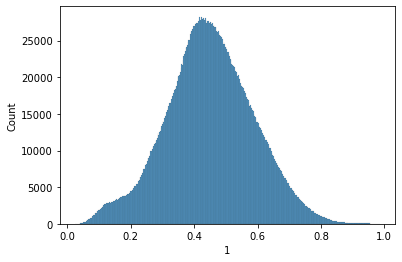

In [117]:
sns.histplot(x = 1, data = pred_proba_df)